# Telco Churn

**Author:** jaume manero<br>
**Date created:** 2022/01/05<br>
**Last modified:** 2020/01/05<br>
**Description:** Telco Churn classifier <br>
    https://www.kaggle.com/blastchar/telco-customer-churn


In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.ticker as mtick 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

sns.set(style = 'white')

import os
print(os.listdir("./"))

from xgboost import XGBClassifier



['.ipynb_checkpoints', '02_telco-churn-prediction.ipynb', '01_K-means.ipynb', 'customer-segmentation-k-means-analysis.ipynb', 'WA_Fn-UseC_-Telco-Customer-Churn.csv', 'Mall_Customers.csv']


In [ ]:
def heatmap(actual, preds, classifier):

   cf_matrix = confusion_matrix(actual, preds, labels=[1,0])
   ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='g')

   ax.set_title('Churn Classifier -'+classifier+'\n')
   ax.set_xlabel('\nPredicted Values')
   ax.set_ylabel('Actual Values ')

   ## Ticket labels - List must be in alphabetical order
   ax.xaxis.set_ticklabels(['False','True'])
   ax.yaxis.set_ticklabels(['False','True'])

   ## Display the visualization of the Confusion Matrix.
   plt.show()
   return
                
heatmap(y_test, preds, 'XGBOOST')

In [2]:
df_cust = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

### Data exploration

In [3]:
print('df_cust shape',df_cust.shape)
df_cust.dtypes

df_cust shape (7043, 21)


customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [4]:
print(df_cust['TotalCharges'])
#df_cust is type object but has an amount
# Converting Total Charges to a numerical data type.
df_cust.TotalCharges = pd.to_numeric(df_cust.TotalCharges, errors='coerce')
df_cust.isnull().sum()

0         29.85
1        1889.5
2        108.15
3       1840.75
4        151.65
         ...   
7038     1990.5
7039     7362.9
7040     346.45
7041      306.6
7042     6844.5
Name: TotalCharges, Length: 7043, dtype: object


customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

After looking at the above output, we can say that there are 11 missing values for Total Charges. Let us replace remove these 11 rows from our data set

In [5]:
#Removing missing values 
df_cust.dropna(inplace = True)
#Remove customer IDs from the data set
df2 = df_cust.iloc[:,1:]
#Convertin the predictor variable in a binary numeric variable
df2['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df2['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df2)
df_dummies.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,1,29.85,29.85,0,1,0,0,1,1,...,0,1,0,0,0,1,0,0,1,0
1,0,34,56.95,1889.50,0,0,1,1,0,1,...,0,0,1,0,1,0,0,0,0,1
2,0,2,53.85,108.15,1,0,1,1,0,1,...,0,1,0,0,0,1,0,0,0,1
3,0,45,42.30,1840.75,0,0,1,1,0,1,...,0,0,1,0,1,0,1,0,0,0
4,0,2,70.70,151.65,1,1,0,1,0,1,...,0,1,0,0,0,1,0,0,1,0


<AxesSubplot:>

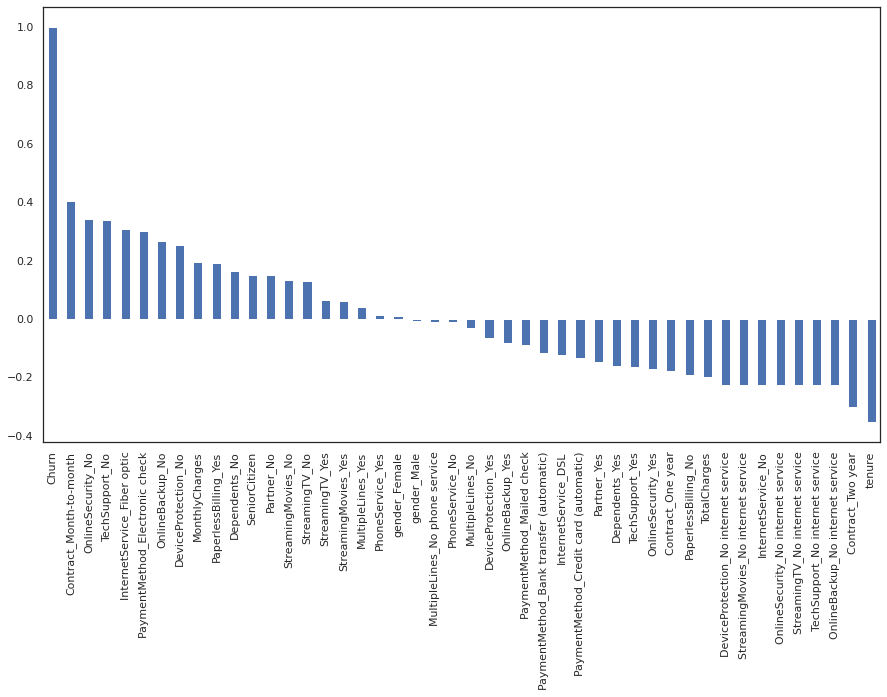

In [6]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

### Predictive Modelling

Logistic Regression, Random Forest, SVM, ADA Boost and XG Boost

**1. Logistic Regression**

In [23]:
# We will use the data frame where we had created dummy variables
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

It is important to scale the variables in logistic regression so that all of them are within a range of 0 to 1. This helped me improve the accuracy from 79.7% to 80.7%. Further, you will notice below that the importance of variables is also aligned with what we are seeing in Random Forest algorithm and the EDA we conducted above.

In [24]:
# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [25]:
# Running logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
result = model.fit(X_train, y_train)

0.8130774697938877


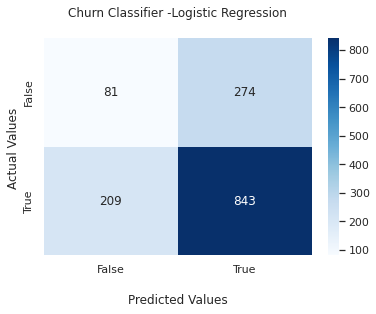

In [82]:
from sklearn import metrics
prediction_test = model.predict(X_test)
# Print the prediction accuracy
print (metrics.accuracy_score(y_test, prediction_test))
heatmap(y_test, preds, 'Logistic Regression')

AxesSubplot(0.125,0.125;0.775x0.755)


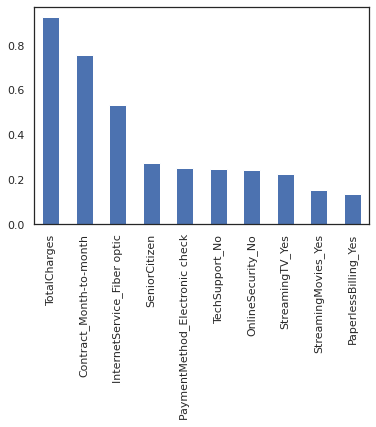

In [27]:
# To get the weights of all the variables
weights = pd.Series(model.coef_[0],
                 index=X.columns.values)
print (weights.sort_values(ascending = False)[:10].plot(kind='bar'))


AxesSubplot(0.125,0.125;0.775x0.755)


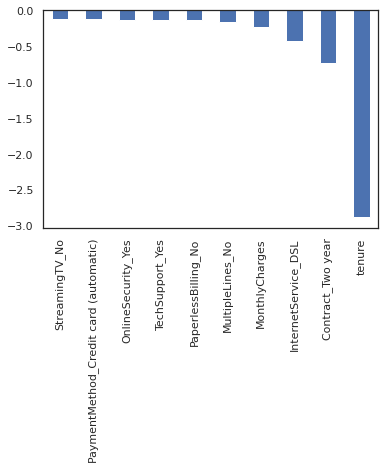

In [28]:
print(weights.sort_values(ascending = False)[-10:].plot(kind='bar'))

**Observations**

We can see that some variables have a negative relation to our predicted variable (Churn), while some have positive relation. Negative relation means that likeliness of churn decreases with that variable. Let us summarize some of the interesting features below:
* As we saw in our EDA, having a 2 month contract reduces chances of churn. 2 month contract along with tenure have the most negative relation with Churn as predicted by logistic regressions
* Having DSL internet service also reduces the proability of Churn
* Lastly, total charges, monthly contracts, fibre optic internet services and seniority can lead to higher churn rates. This is interesting because although fibre optic services are faster, customers are  likely to churn because of it. I think we need to explore more to better understad why this is happening. 

Any hypothesis on the above would be really helpful! 

**2. Random Forest**

In [83]:
X_train

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
850,0.0,0.014085,0.065672,0.004985,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2122,0.0,0.549296,0.239801,0.195898,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
596,0.0,0.042254,0.470647,0.025202,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
206,0.0,1.000000,0.370149,0.480083,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5006,1.0,0.985915,0.338806,0.432293,0.0,1.0,0.0,1.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599,0.0,0.211268,0.560199,0.132899,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5695,0.0,0.253521,0.682587,0.178352,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1361,0.0,0.126761,0.670149,0.091744,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1547,0.0,0.422535,0.619900,0.283037,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [87]:
X_train.values

array([[0.        , 0.01408451, 0.06567164, ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.54929577, 0.239801  , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.04225352, 0.47064677, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.        , 0.12676056, 0.67014925, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.42253521, 0.6199005 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.02816901, 0.45124378, ..., 0.        , 1.        ,
        0.        ]])

0.8088130774697939


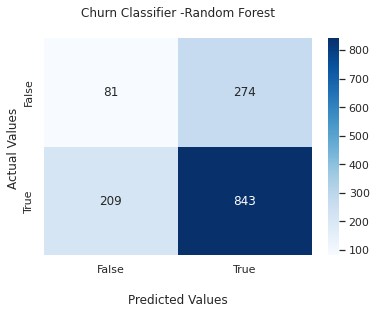

In [93]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train.values, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test.values)

print (metrics.accuracy_score(y_test, prediction_test))
heatmap(y_test, preds, 'Random Forest')

<AxesSubplot:>

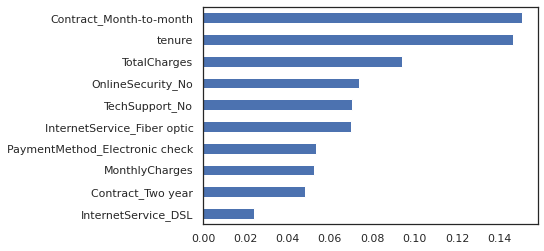

In [30]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

**3. Support Vecor Machine (SVM)**

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

0.820184790334044


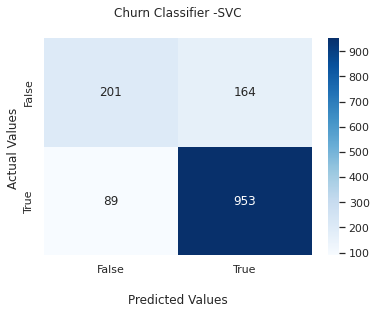

In [80]:
from sklearn.svm import SVC

model.svm = SVC(kernel='linear') 
model.svm.fit(X_train,y_train)
preds = model.svm.predict(X_test)
print(metrics.accuracy_score(y_test, preds))
heatmap(y_test, preds, 'SVC')

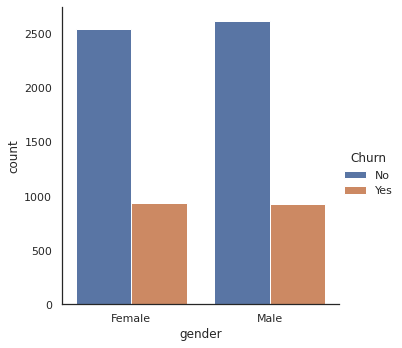

In [35]:
ax1 = sns.catplot(x="gender", kind="count", hue="Churn", data=df_cust,
                  estimator=lambda x: sum(x==0)*100.0/len(x))
#ax1.yaxis.set_major_formatter(mtick.PercentFormatter())

**4. ADA Boost**

0.8159203980099502


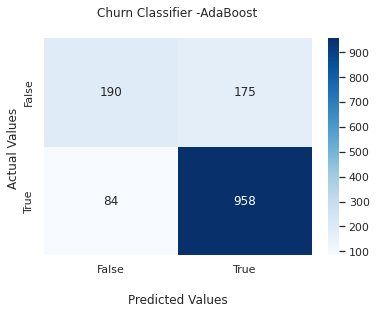

In [79]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier
model = AdaBoostClassifier()
# n_estimators = 50 (default value) 
# base_estimator = DecisionTreeClassifier (default value)
model.fit(X_train,y_train)
preds = model.predict(X_test)
print(metrics.accuracy_score(y_test, preds))
heatmap(y_test, preds, 'AdaBoost')

**5. XG Boost**

0.8237384506041222


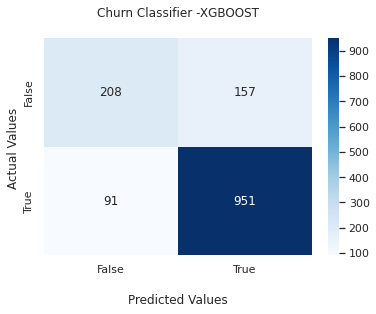

In [78]:

model = XGBClassifier(use_label_encoder = False, eval_metric='logloss',
                     objective='reg:logistic', n_estimators=36)
model.fit(X_train, y_train)
preds = model.predict(X_test)
print(metrics.accuracy_score(y_test, preds))
heatmap(y_test, preds, 'XGBOOST')